In [ ]:
import xarray as xr
import numpy as np
import dask.array as da
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

test_ds = xr.open_zarr('test_data_normalised.zarr', consolidated=True)

#select channels, default is all channels but can remove for when performing ablation
all_inputs  = test_ds['inputs'].isel(channel=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]).data
all_centers = test_ds['centers'].data
all_labels  = test_ds['labels'].data

# defining class for testing
class ERA5GridWithCoords(Dataset):
    def __init__(self, inputs, centers, labels):
        self.inputs = inputs
        self.centers = centers
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Trigger computation on-the-fly for a single batch
        input_sample = torch.tensor(self.inputs[idx].compute(), dtype=torch.float32).permute(2, 0, 1)
        center_sample = torch.tensor(self.centers[idx].compute(), dtype=torch.float32)
        label_sample = torch.tensor(self.labels[idx].compute(), dtype=torch.float32)
        return input_sample, center_sample, label_sample

# =============================================================================
# Build DataLoader
# =============================================================================
batch_size = 16
dataset    = ERA5GridWithCoords(all_inputs, all_centers, all_labels)
loader     = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f" DataLoader ready with {len(dataset)} samples. Each batch = (inputs, centers, labels).")
print(all_inputs.shape)  

 DataLoader ready with 20000 samples. Each batch = (inputs, centers, labels).
(20000, 80, 107, 16)


In [ ]:
# need to define architecture for testing - run if testing ResNet with coordinates
# =============================================================================

class block(nn.Module):
    def __init__(
        self, in_channels, mid_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, mid_channels,
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion,
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels * self.expansion)
        self.silu = nn.SiLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, z):
        identity = z.clone()

        z = self.conv1(z)
        z = self.bn1(z)
        z = self.silu(z)
        z = self.conv2(z)
        z = self.bn2(z)
        z = self.silu(z)
        z = self.conv3(z)
        z = self.bn3(z)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        z += identity
        z = self.silu(z)
        return z

class ResNetWithCoords(nn.Module):
    def __init__(self, block, layers, image_channels, coord_dim=2):
        super(ResNetWithCoords, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0],
                                       mid_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1],
                                       mid_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2],
                                       mid_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3],
                                       mid_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adding two more dimensions for the coordinates
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 + coord_dim, 2048),
            # nn.Linear(512 * 4, 2048),
            nn.ReLU(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, z, coords):
        """
        z: Tensor of shape (batch, input_channels, H, W)
        coords: Tensor of shape (batch, 2) giving (lat_center, lon_center)
        """
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.silu(z)
        z = self.maxpool(z)
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.avgpool(z)
        z = z.view(z.size(0), -1)

        # Concatenate coordinates
        z = torch.cat([z, coords], dim=1)  # [batch, F + 2]
        z = self.fc(z)
        return z

    def _make_layer(self, block, num_residual_blocks, mid_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != mid_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, mid_channels * 4,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(mid_channels * 4)
            )

        layers.append(block(self.in_channels, mid_channels,
                            identity_downsample, stride))
        self.in_channels = mid_channels * 4
        
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, mid_channels))

        return nn.Sequential(*layers)


def SDS_ResNetWithCoords(img_channel):
    return ResNetWithCoords(block, [3, 4, 6, 3], img_channel)

input_channels = all_inputs.shape[-1]

model = SDS_ResNetWithCoords(input_channels)  # Match to your current data
model.load_state_dict(torch.load("resnet_with_coords_1980_2010_e3_normalised_coords_epoch_15.pth"))
model.eval()

ResNetWithCoords(
  (conv1): Conv2d(22, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (silu): SiLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

In [ ]:
# need to define architecture for testing - run if testing SENet with coordinates
# =============================================================================

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        b, c, _, _ = z.size()
        y = self.avg_pool(z).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return z * y.expand_as(z)


class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None, stride=1, reduction=4):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.silu = nn.SiLU(inplace=True)
        self.se = SELayer(planes * 4, reduction)
        self.downsample = downsample

    def forward(self, z):
        identity = z

        z = self.conv1(z)
        z = self.bn1(z)
        z = self.silu(z)
        z = self.conv2(z)
        z = self.bn2(z)
        z = self.silu(z)
        z = self.conv3(z)
        z = self.bn3(z)
        z = self.se(z)

        if self.downsample is not None:
            identity = self.downsample(identity)

        z += identity
        z = self.silu(z)

        return z
    

class SENetWithCoords(nn.Module):
    def __init__(self, block, layers, image_channels, coord_dim=2):
        super(SENetWithCoords, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], mid_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], mid_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], mid_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], mid_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Adding two more dimensions for the coordinates
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 + coord_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, z, coords):
        """
        z: Tensor of shape (batch, input_channels, H, W)
        coords: Tensor of shape (batch, 2) giving (lat_center, lon_center)
        """
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.silu(z)
        z = self.maxpool(z)
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z)
        z = self.avgpool(z)
        z = z.view(z.size(0), -1)

        # Concatenate coordinates
        z = torch.cat([z, coords], dim=1)  # [batch, F + 2]
        z = self.fc(z)
        return z

    def _make_layer(self, block, num_residual_blocks, mid_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != mid_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, mid_channels * 4,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(mid_channels * 4)
            )

        layers.append(block(self.in_channels, mid_channels,
                            identity_downsample, stride))
        self.in_channels = mid_channels * 4
        
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, mid_channels))

        return nn.Sequential(*layers)


def SDS_SENetWithCoords(img_channel):
    return SENetWithCoords(SEBottleneck, [3, 4, 6, 3], img_channel)

input_channels = all_inputs.shape[-1]

model = SDS_SENetWithCoords(input_channels)  # Match to your current data
model.load_state_dict(torch.load("SENet_with_coords_1980_2010_reduction_4_weightdecaye3.pth"))
model.eval()

SENetWithCoords(
  (conv1): Conv2d(22, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (silu): SiLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU(inplace=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequ

# Testing functions to assess accuracy, and F1 score - adjust desired threshold accordingly 

In [ ]:
# testing functions to assess accuracy, and f1 score - adjust desired threshold accordingly 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt 

# required for cross basin applications to ensure domains are the same size
def resize_inputs(inputs, target_size=(80, 107)):
    # Continuous channels (0 to 19 and 21 onwards)
    cont_channels = torch.cat([inputs[:, :20], inputs[:, 21:]], dim=1)
    cont_resized = F.interpolate(cont_channels, size=target_size, mode='bilinear', align_corners=False)

    # Discrete sea-land mask (channel 20)
    discrete_channel = inputs[:, 20:21]  # preserve shape (B, 1, H, W)
    discrete_resized = F.interpolate(discrete_channel, size=target_size, mode='nearest')

    # Reconstruct full tensor
    return torch.cat([cont_resized[:, :20], discrete_resized, cont_resized[:, 20:]], dim=1)

def evaluate_model_full(model, test_loader, threshold=0.55):
    """
    Evaluate a model that takes both the 4D input and a (lat,lon) coordinate pair.
    test_loader should yield (inputs, centers, labels).
    """
    device = torch.device("mps" if torch.backends.mps.is_available() 
                          else "cuda" if torch.cuda.is_available() 
                          else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, centers, labels in test_loader:
            # move everything to device
            
            # inputs = resize_inputs(inputs, target_size=(80, 107)) 
            inputs  = inputs.to(device)
            centers = centers.to(device)    # (B, 2)
            labels  = labels.to(device)     # (B,)

            # ######## Useful debugging visualisation #######
            # # Choose the timestep to visualize
            # timestep = 1  # or any valid index < batch size

            # # Move input and label to CPU and prepare for plotting
            # x = inputs[timestep].cpu().numpy()  # shape: (C, H, W)
            # label = labels[timestep].item()     # move to CPU and get scalar

            # # Number of channels
            # num_channels = x.shape[0]

            # # Define grid size for subplots
            # cols = 6
            # rows = int(np.ceil(num_channels / cols))

            # # Create the figure
            # fig, axs = plt.subplots(rows, cols, figsize=(18, 3 * rows))
            # fig.suptitle(f"Test Sample at Timestep {timestep} - Label: {int(label)}", fontsize=16)

            # # Plot each channel
            # for i in range(num_channels):
            #     row, col = divmod(i, cols)
            #     ax = axs[row, col] if rows > 1 else axs[col]
            #     im = ax.imshow(x[i], cmap='viridis', aspect='auto')
            #     ax.set_title(f"Channel {i}", fontsize=10)
            #     ax.axis("off")
            #     fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # # Turn off unused subplots
            # for j in range(num_channels, rows * cols):
            #     row, col = divmod(j, cols)
            #     ax = axs[row, col] if rows > 1 else axs[col]
            #     ax.axis('off')

            # plt.tight_layout(rect=[0, 0, 1, 0.96])
            # plt.show()
            ########

            # forward pass now takes two args
            outputs = model(inputs, centers).squeeze()  # (B,)
            # print(outputs)
            
            # binarize
            preds = (outputs >= threshold).int().cpu().numpy()
            labs  = labels.int().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labs)



    # compute metrics
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score    (all_labels, all_preds)
    cm  = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    print("Evaluation Results:")
    print(f"  Threshold:      {threshold}")
    print(f"  Accuracy:       {acc:.4f}")
    print(f"  F1 Score:       {f1:.4f}")
    print(f"  True Positives: {tp}")
    print(f"  True Negatives: {tn}")
    print(f"  False Positives:{fp}")
    print(f"  False Negatives:{fn}")

    return acc, f1, all_preds, all_labels, cm

# usage:
acc, f1, preds, labs, cm = evaluate_model_full(model, loader)

Evaluation Results:
  Threshold:      0.55
  Accuracy:       0.9902
  F1 Score:       0.1256
  True Positives: 14
  True Negatives: 19791
  False Positives:13
  False Negatives:182


In [ ]:
#for testing all different threshold ranges to maximise performance
thresholds = np.arange(0,1,0.05)

for t in thresholds:
    acc, f1, preds, labs, cm = evaluate_model_full(model, loader, threshold=t)
    print(f"Threshold: {t}, Accuracy: {acc}, F1 Score: {f1}")

# The next set of cells are additional testing functions which were not used throughout the investigation but can be useful for debugging and better understanding of features in the model

Baseline Prediction: 0.0003

-- Channel Ablation Analysis --
Channel 0: ΔPrediction = 0.0002
Channel 1: ΔPrediction = 0.0001
Channel 2: ΔPrediction = 0.0001
Channel 3: ΔPrediction = 0.0001
Channel 4: ΔPrediction = 0.3859
Channel 5: ΔPrediction = 0.0001
Channel 6: ΔPrediction = 0.0002
Channel 7: ΔPrediction = 0.0002
Channel 8: ΔPrediction = 0.0002
Channel 9: ΔPrediction = 0.0002
Channel 10: ΔPrediction = 0.0001
Channel 11: ΔPrediction = 0.0001
Channel 12: ΔPrediction = 0.0002
Channel 13: ΔPrediction = 0.0002
Channel 14: ΔPrediction = 0.0053
Channel 15: ΔPrediction = 0.0002
Channel 16: ΔPrediction = 0.0001
Channel 17: ΔPrediction = 0.0002
Channel 18: ΔPrediction = 0.2574
Channel 19: ΔPrediction = 0.0002
Channel 20: ΔPrediction = 0.0002
Channel 21: ΔPrediction = 0.0002

-- Coordinate Ablation Analysis --
Coordinate 0: ΔPrediction = 0.0541
Coordinate 1: ΔPrediction = 0.0001


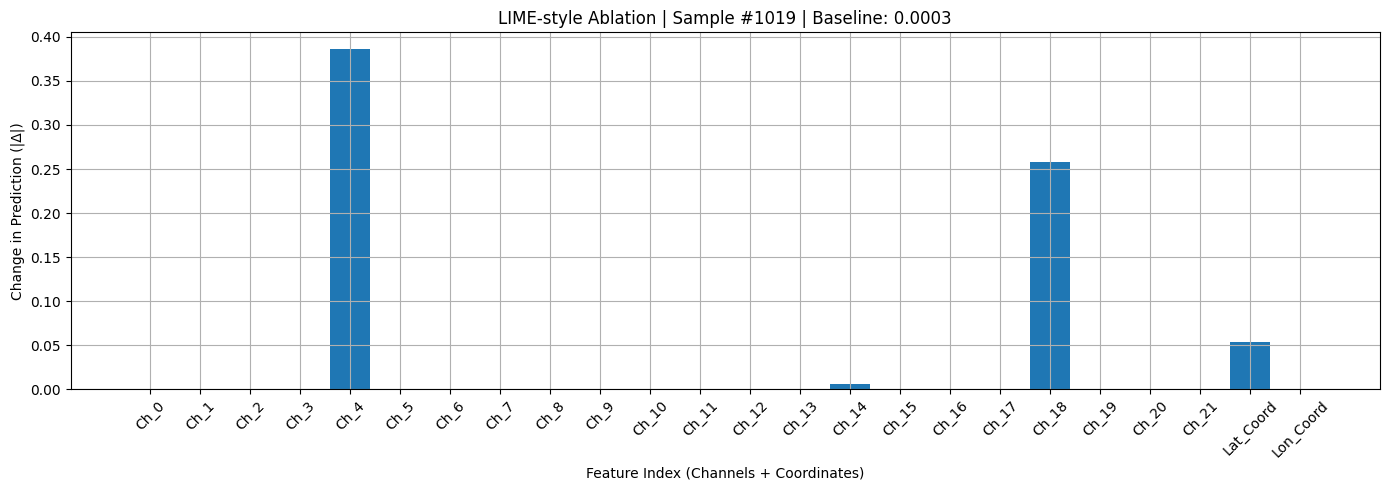

In [120]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Use the trained model
model.eval()
device = next(model.parameters()).device

# Choose a test sample
idx = 1019
x_orig = all_inputs[idx]        # shape: (H, W, C)
coords_orig = all_centers[idx]   # shape: (2,)

# Convert to tensors
x_tensor = torch.tensor(x_orig, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (1, C, H, W)
coords_tensor = torch.tensor(coords_orig, dtype=torch.float32).unsqueeze(0).to(device)          # (1, 2)

# Get baseline prediction
with torch.no_grad():
    baseline_pred = model(x_tensor, coords_tensor).item()

print(f"Baseline Prediction: {baseline_pred:.4f}")

# -----------------------------------------------------------------------------
# 🔄 Function to ablate a channel or coordinate and check effect on prediction
# -----------------------------------------------------------------------------
def ablate_feature_and_predict(x, coords, feature_idx, is_channel=True):
    """
    Ablates a feature (either a channel or a coordinate) and returns the model prediction.
    If is_channel is True, the index is for channels; otherwise, it's for coordinates.
    """
    x_mod = x.clone()
    coords_mod = coords.clone()
    
    if is_channel:
        x_mod[0, feature_idx, :, :] = 0.0  # zero out the channel
    else:
        coords_mod[0, feature_idx] = 0.0   # zero out the coordinate
    
    with torch.no_grad():
        pred = model(x_mod, coords_mod).item()
    
    return pred

# -----------------------------------------------------------------------------
# 🔄 Compute change in prediction for each channel and coordinate
# -----------------------------------------------------------------------------
num_channels = x_tensor.shape[1]
importance_scores = []

print("\n-- Channel Ablation Analysis --")
for ch in range(num_channels):
    pred = ablate_feature_and_predict(x_tensor, coords_tensor, ch, is_channel=True)
    delta = abs(baseline_pred - pred)
    importance_scores.append(delta)
    print(f"Channel {ch}: ΔPrediction = {delta:.4f}")

# Now let's ablate the coordinates too
print("\n-- Coordinate Ablation Analysis --")
for i in range(2):
    pred = ablate_feature_and_predict(x_tensor, coords_tensor, i, is_channel=False)
    delta = abs(baseline_pred - pred)
    importance_scores.append(delta)
    print(f"Coordinate {i}: ΔPrediction = {delta:.4f}")

# -----------------------------------------------------------------------------
# 🔄 Plot results
# -----------------------------------------------------------------------------
plt.figure(figsize=(14, 5))
plt.bar(range(num_channels + 2), importance_scores)
plt.xlabel("Feature Index (Channels + Coordinates)")
plt.ylabel("Change in Prediction (|Δ|)")
plt.title(f"LIME-style Ablation | Sample #{idx} | Baseline: {baseline_pred:.4f}")
plt.xticks(list(range(num_channels + 2)), 
           labels=[f"Ch_{i}" for i in range(num_channels)] + ["Lat_Coord", "Lon_Coord"],
           rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Found 63 positive samples. Running analysis...


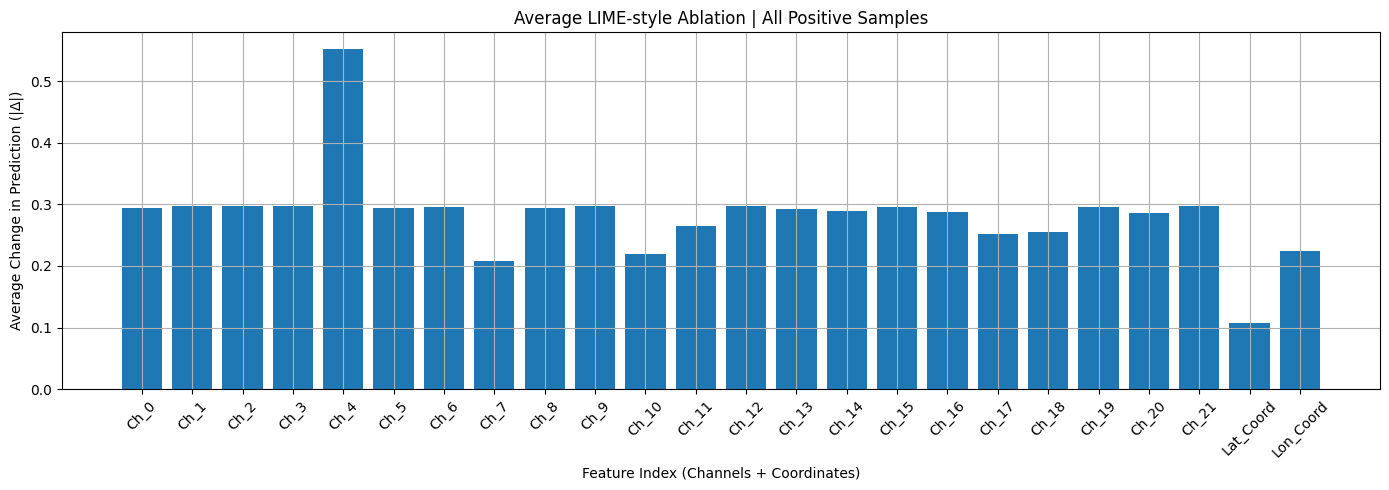

In [116]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Use the trained model
model.eval()
device = next(model.parameters()).device

# Find all positive samples
positive_indices = np.argwhere(all_labels == 1).flatten()

# Initialize accumulators for impact scores
num_channels = all_inputs.shape[-1]
channel_importance_scores = np.zeros(num_channels)
coord_importance_scores = np.zeros(2)
num_positives = len(positive_indices)

print(f"Found {num_positives} positive samples. Running analysis...")

# -----------------------------------------------------------------------------
# 🔄 Function to ablate a feature and check effect on prediction
# -----------------------------------------------------------------------------
def ablate_feature_and_predict(x, coords, feature_idx, is_channel=True):
    """
    Ablates a feature (either a channel or a coordinate) and returns the model prediction.
    If is_channel is True, the index is for channels; otherwise, it's for coordinates.
    """
    x_mod = x.clone()
    coords_mod = coords.clone()
    
    if is_channel:
        x_mod[0, feature_idx, :, :] = 0.0  # zero out the channel
    else:
        coords_mod[0, feature_idx] = 0.0   # zero out the coordinate
    
    with torch.no_grad():
        pred = model(x_mod, coords_mod).item()
    
    return pred

# -----------------------------------------------------------------------------
# 🔄 Loop through each positive sample and calculate deltas
# -----------------------------------------------------------------------------
for idx in positive_indices:
    # Load the original sample
    x_orig = all_inputs[idx]        # shape: (H, W, C)
    coords_orig = all_centers[idx]  # shape: (2,)

    # Convert to tensors
    x_tensor = torch.tensor(x_orig, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (1, C, H, W)
    coords_tensor = torch.tensor(coords_orig, dtype=torch.float32).unsqueeze(0).to(device)          # (1, 2)

    # Get baseline prediction
    with torch.no_grad():
        baseline_pred = model(x_tensor, coords_tensor).item()

    # -----------------------------------------------------------------------------
    # 🔄 Compute change in prediction for each channel
    # -----------------------------------------------------------------------------
    for ch in range(num_channels):
        pred = ablate_feature_and_predict(x_tensor, coords_tensor, ch, is_channel=True)
        delta = abs(baseline_pred - pred)
        channel_importance_scores[ch] += delta
    
    # -----------------------------------------------------------------------------
    # 🔄 Compute change in prediction for each coordinate
    # -----------------------------------------------------------------------------
    for i in range(2):
        pred = ablate_feature_and_predict(x_tensor, coords_tensor, i, is_channel=False)
        delta = abs(baseline_pred - pred)
        coord_importance_scores[i] += delta

# -----------------------------------------------------------------------------
# 🔄 Average the impact scores over the number of positive samples
# -----------------------------------------------------------------------------
channel_importance_scores /= num_positives
coord_importance_scores /= num_positives

# -----------------------------------------------------------------------------
# 🔄 Plot results
# -----------------------------------------------------------------------------
plt.figure(figsize=(14, 5))
plt.bar(range(num_channels + 2), 
        np.concatenate((channel_importance_scores, coord_importance_scores)))
plt.xlabel("Feature Index (Channels + Coordinates)")
plt.ylabel("Average Change in Prediction (|Δ|)")
plt.title("Average LIME-style Ablation | All Positive Samples")
plt.xticks(list(range(num_channels + 2)), 
           labels=[f"Ch_{i}" for i in range(num_channels)] + ["Lat_Coord", "Lon_Coord"],
           rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Below is a SHAP analysis, the SHAP package will need to be downloaded. This proves to be difficult with the current package requirements but with the correct version of CMAKE this can be overcome. 

In [58]:
import shap
import torch
import numpy as np

# ---------------------------
# Load your model
# ---------------------------

# Set device
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device)

# ---------------------------
# Prepare Data
# ---------------------------
# Assuming your data is in (Time, Width, Height, Channels)
# Sample your data (reduced to 2 for memory reasons)
sample_coords = torch.tensor(all_centers[:50], dtype=torch.float32).to(device)
sample_inputs = torch.tensor(all_inputs[:50], dtype=torch.float32).to(device)  # (2, 107, 80, 22)

# Permute to NCHW format
sample_inputs = sample_inputs.permute(0, 3, 1, 2)  # (2, 22, 107, 80)

# ---------------------------
# Define a Prediction Function
# ---------------------------
def predict_fn(data):
    """
    Data comes in as (N, 22, 107, 80) as expected by the model.
    """
    inputs = torch.tensor(data, dtype=torch.float32).to(device)
    batch_size = inputs.shape[0]
    
    # Slice only the required coordinates for the current batch
    coords = sample_coords[:batch_size]  

    with torch.no_grad():
        outputs = model(inputs, coords).cpu().numpy()
    return outputs

# ---------------------------
# Initialize Partition Explainer
# ---------------------------
print("Initializing Partition Explainer...")

# Define a masker for partition-based masking
masker = shap.maskers.Image("blur(128,128)", sample_inputs[0].cpu().numpy().shape)

# Create the SHAP Explainer
explainer = shap.Explainer(predict_fn, masker)

# ---------------------------
# Run SHAP Analysis
# ---------------------------
print("Running Partition SHAP analysis... this may take a while.")
shap_values = explainer(sample_inputs.cpu().numpy(), max_evals=100, batch_size=1)

# ---------------------------
# Plot Results
# ---------------------------
print("Generating plots...")
# for i in range(2):  # Loop through the 2 samples
#     shap.image_plot([shap_values[i]], pixel_values=sample_inputs[i].cpu().numpy())

Initializing Partition Explainer...
Running Partition SHAP analysis... this may take a while.


PartitionExplainer explainer: 51it [00:31,  1.14it/s]                        

Generating plots...


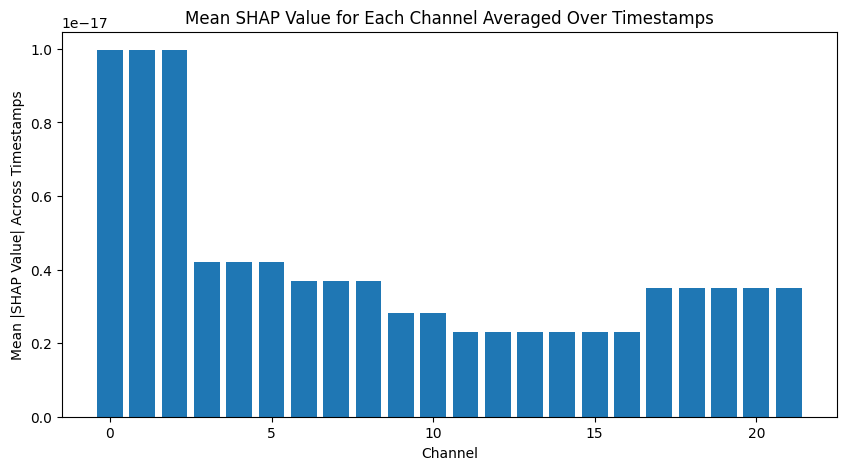

Top 5 Important Channels: [4 3 1 0 2]


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------------------------
# Overlay SHAP on Original Image
# ---------------------------
def plot_overlay(shap_values, original_image, channel_names=None):
    """
    Overlays SHAP explanations on the original image for better interpretability.
    """
    num_channels = shap_values.shape[0]
    
    plt.figure(figsize=(15, 3 * num_channels))
    
    for i in range(num_channels):
        plt.subplot(num_channels, 2, 2 * i + 1)
        plt.imshow(original_image[i], cmap='gray')
        plt.title(f"Original Channel {i}" if not channel_names else channel_names[i])
        plt.axis('off')
        
        plt.subplot(num_channels, 2, 2 * i + 2)
        plt.imshow(shap_values[i], cmap='RdBu', alpha=0.6)
        plt.title(f"SHAP Explanation Channel {i}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ---------------------------
# Mean SHAP Calculation Across Timestamps
# ---------------------------
# Initialize an array to collect the mean absolute SHAP values for each sample and channel
list_od = []

for i in range(20):  # Loop through all 20 timestamps
    shap_values_sample = shap_values[i].values  # Shape: (22, 80, 107, 1)

    # Remove the last dimension if it's just 1 (squeeze)
    shap_values_sample = np.squeeze(shap_values_sample, axis=-1)
    
    # Compute the mean absolute SHAP value across spatial dimensions (80, 107)
    mean_abs_shap = np.mean(np.abs(shap_values_sample), axis=(1, 2))  # Shape: (22,)
    
    # Append to the list
    list_od.append(mean_abs_shap)

# Convert list to a NumPy array for easier manipulation
list_od = np.array(list_od)  # Shape: (20, 22)

# ---------------------------
# Calculate the Mean Across Timestamps
# ---------------------------
mean_across_timestamps = np.mean(list_od, axis=0)  # Shape: (22,)

# ---------------------------
# Plot the Results
# ---------------------------
plt.figure(figsize=(10, 5))
plt.bar(range(len(mean_across_timestamps)), mean_across_timestamps)
plt.xlabel("Channel")
plt.ylabel("Mean |SHAP Value| Across Timestamps")
plt.title("Mean SHAP Value for Each Channel Averaged Over Timestamps")
plt.show()

# ---------------------------
# Top N Important Channels
# ---------------------------
N = 5
top_n_channels = np.argsort(mean_across_timestamps)[-N:]
print(f"Top {N} Important Channels: {top_n_channels}")

# Visualising training and testing losses

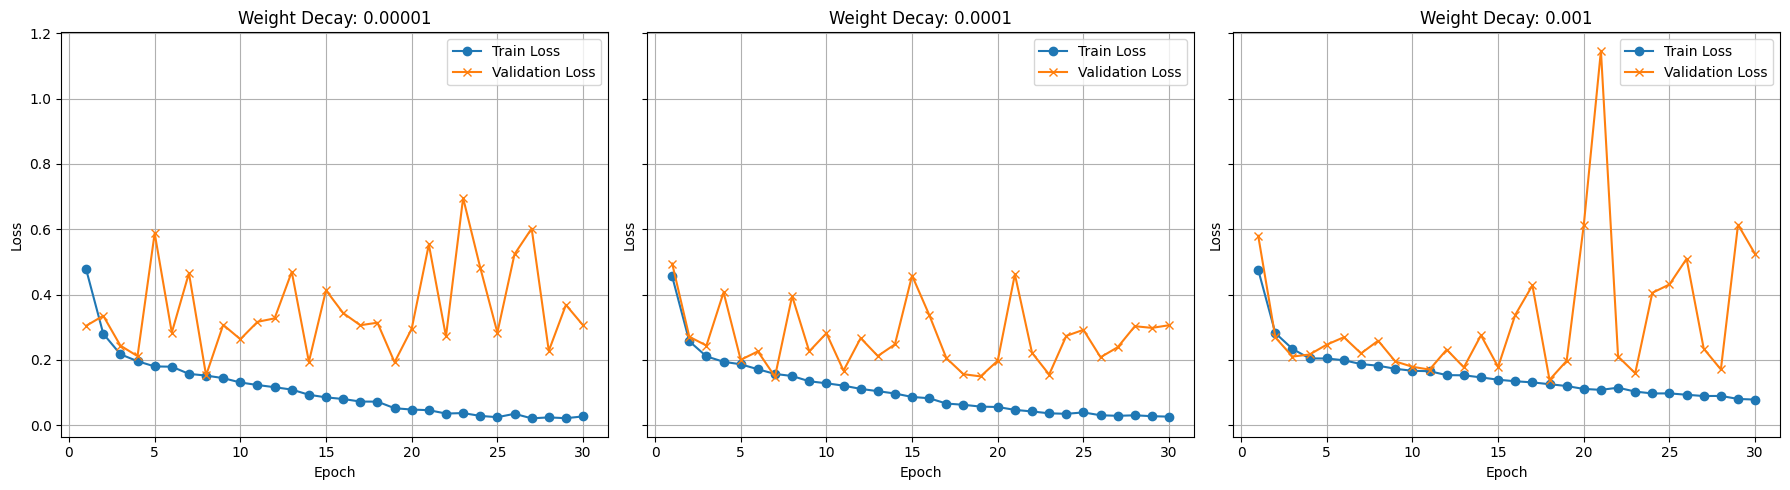

In [125]:
import matplotlib.pyplot as plt

# Define the epochs
epochs = list(range(1, 31))

# Data for each model
data = {
    "Weight Decay: 0.00001": {
        "train": [
            0.4776, 0.2803, 0.2175, 0.1961, 0.1802, 0.1794, 0.1574, 0.1522, 0.1444, 0.1311,
            0.1233, 0.1166, 0.1093, 0.0935, 0.0855, 0.0805, 0.0727, 0.0724, 0.0523, 0.0482,
            0.0463, 0.0360, 0.0374, 0.0288, 0.0248, 0.0352, 0.0213, 0.0242, 0.0218, 0.0272
        ],
        "val": [
            0.3045, 0.3353, 0.2439, 0.2117, 0.5879, 0.2838, 0.4658, 0.1529, 0.3075, 0.2635,
            0.3167, 0.3273, 0.4698, 0.1943, 0.4133, 0.3436, 0.3063, 0.3141, 0.1930, 0.2955,
            0.5536, 0.2721, 0.6959, 0.4826, 0.2836, 0.5237, 0.6024, 0.2276, 0.3686, 0.3061
        ]
    },
    "Weight Decay: 0.0001": {
        "train": [
            0.4558, 0.2572, 0.2110, 0.1944, 0.1868, 0.1716, 0.1572, 0.1509, 0.1348, 0.1286,
            0.1214, 0.1114, 0.1045, 0.0973, 0.0868, 0.0828, 0.0666, 0.0628, 0.0572, 0.0560,
            0.0472, 0.0424, 0.0367, 0.0352, 0.0394, 0.0307, 0.0290, 0.0306, 0.0279, 0.0265
        ],
        "val": [
            0.4951, 0.2710, 0.2441, 0.4069, 0.2004, 0.2262, 0.1489, 0.3957, 0.2263, 0.2818,
            0.1673, 0.2669, 0.2121, 0.2478, 0.4584, 0.3380, 0.2056, 0.1564, 0.1497, 0.1978,
            0.4621, 0.2219, 0.1554, 0.2737, 0.2922, 0.2084, 0.2390, 0.3033, 0.2982, 0.3063
        ]
    },
    "Weight Decay: 0.001": {
        "train": [
            0.4759, 0.2822, 0.2338, 0.2047, 0.2045, 0.1991, 0.1874, 0.1824, 0.1730, 0.1668,
            0.1656, 0.1536, 0.1530, 0.1467, 0.1395, 0.1348, 0.1314, 0.1258, 0.1202, 0.1113,
            0.1085, 0.1151, 0.1032, 0.0975, 0.0977, 0.0935, 0.0896, 0.0899, 0.0807, 0.0787
        ],
        "val": [
            0.5801, 0.2690, 0.2103, 0.2168, 0.2469, 0.2696, 0.2202, 0.2589, 0.1955, 0.1791,
            0.1705, 0.2318, 0.1773, 0.2755, 0.1788, 0.3380, 0.4282, 0.1391, 0.1974, 0.6136,
            1.1466, 0.2105, 0.1595, 0.4056, 0.4312, 0.5098, 0.2344, 0.1710, 0.6141, 0.5241
        ]
    }
}

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (title, losses) in zip(axes, data.items()):
    ax.plot(epochs, losses["train"], label='Train Loss', marker='o')
    ax.plot(epochs, losses["val"], label='Validation Loss', marker='x')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# For running with no coordinates but distance from shoreline instead. Shoreline plots have been generated for the WP and the NA but if tested in other basins will need to be generated. 

In [ ]:


import xarray as xr
import numpy as np
import dask.array as da
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import RegularGridInterpolator
import pickle

# -----------------------------------------------------------------------------
# Load Test Data
# -----------------------------------------------------------------------------
test_ds = xr.open_zarr('test_data_normalised_NA.zarr', consolidated=True)

# Select subset of channels
# selected_channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 16, 17, 18, 19, 20, 21]
all_inputs  = test_ds['inputs'].data
all_centers = test_ds['centers'].data
all_labels  = test_ds['labels'].data

# -----------------------------------------------------------------------------
# Load Shoreline Interpolator
# -----------------------------------------------------------------------------
with open("shoreline_distance_lookup_wp.pkl", "rb") as f:
    shoreline_data = pickle.load(f)

shoreline_distance_lookup = RegularGridInterpolator(
    (shoreline_data["lat_vals"], shoreline_data["lon_vals"]),
    shoreline_data["distance_norm"],
    bounds_error=False,
    fill_value=np.nan
)

# -----------------------------------------------------------------------------
# PyTorch Dataset with Derived Inputs
# -----------------------------------------------------------------------------
class ERA5GridWithShoreline(Dataset):
    def __init__(self, inputs, centers, labels):
        self.inputs = inputs
        self.centers = centers  # (lat, lon)
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        img_np   = self.inputs[idx].compute()           # (H, W, C)
        coord_np = self.centers[idx].compute()          # (2,)
        label_np = float(self.labels[idx].compute())    # scalar

        lat, lon = coord_np
        norm_lat = lat / 90.0
        shoreline_dist = shoreline_distance_lookup([[lat, lon]])[0]
        shoreline_dist = np.nan_to_num(shoreline_dist, nan=0.0)

        coord_final = np.array([norm_lat, shoreline_dist], dtype=np.float32)

        return (
            torch.tensor(img_np).permute(2, 0, 1).float(),     # input image
            torch.tensor(coord_final).float(),                 # (norm_lat, shoreline)
            torch.tensor(label_np).float()                     # binary label
        )

# -----------------------------------------------------------------------------
# Create DataLoader
# -----------------------------------------------------------------------------
batch_size = 16
dataset    = ERA5GridWithShoreline(all_inputs, all_centers, all_labels)
loader     = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Test DataLoader ready with {len(dataset)} samples. Each batch = (input, [lat_norm, shoreline_dist], label)")
print("Input shape:", all_inputs.shape)